# Bayesian Inference

## Sampling

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
fi = open('filename.txt', 'r+')
filename = int(fi.readline())
fi.close()

# path = '/home/wgshen/BIRL/MS_model_newlikeli_split_scale/train/'
# path_store = '/scratch/xhuan_root/xhuan1/wgshen/newlikeli_emcee_split_scale/train/'
path = './'
path_store = './'

# import warnings
# warnings.filterwarnings("ignore")
    
# Standard imports that we will need in the rest of the notebook.
import numpy as np
from numpy import inf
from scipy import stats
import time

# Discrete distributions and sampling
from gym import Env, spaces, utils
from gym.utils import seeding

# Inverse reinforcement learning
from inv_reinforce_learning_state_action import compute_s_a_visitations, vi_boltzmann, compute_D

# Plot
import matplotlib.pyplot as plt

# Generate initial state distribution
from generate_ISD import generate_ISD

# Generate trajectories
from generate_trajectories import generate_trajectories

# Bayesian inference
import emcee
from multiprocessing import Pool
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Construct MDP
from environment import MDP, Environment
transition_proba = np.load(path+'/data/transition_proba.npy')
state_feature_name = np.load(path+'/data/state_feature_name.npy', allow_pickle=True)
action_feature_name = np.load(path+'/data/action_feature_name.npy', allow_pickle=True)
state_feature = np.load(path+'/data/state_feature.npy')
action_feature = np.load(path+'/data/action_feature.npy')
initial_state_dist = np.load(path+'/data/initial_state_dist.npy')
# initial_state_df_ind = np.load(path+'/data/initial_state_df_ind.npy')
valid_init = np.load(path+'/data/valid_init_state.npy')
environment = Environment(state_feature_name, action_feature_name, 
                          state_feature, action_feature, transition_proba, initial_state_dist)
mdp = MDP(environment)
mdp.valid_sa = np.sum(mdp.T, axis=2)
mdp.valid_s = np.sum(state_feature, axis=1) > 0

Initial state distribution:  [1.27462723e-05 9.19313902e-05 9.19313902e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [5]:
np.sum(mdp.T)

SystemError: CPUDispatcher(<function _calc_counts_invidx at 0x1a29633c20>) returned a result with an error set

In [ ]:
filename = 2

In [4]:
# @as_op(itypes=[tt.dvector], otypes=[tt.dscalar])
def loglikeli(theta):
    h = horizon
    gamma = 1
    temperature = 1/5
    theta_state = (theta.reshape(-1,1))[:state_feature.shape[1],:]
    theta_action = (theta.reshape(-1,1))[state_feature.shape[1]:,:]
    r_s = np.squeeze(np.asarray(np.dot(state_feature, theta_state)))
    r_a = np.squeeze(np.asarray(np.dot(action_feature, theta_action)))
    V, Q, policy = vi_boltzmann(mdp, gamma, r_s, r_a, h, temperature)
    s, a = behavior_state[:n_data_list[i]*h], behavior_action[:n_data_list[i]*h]
    log_like = np.log(policy[s,a]).sum()
    return np.array(log_like)

def prior(theta, mu=None, sigma=None):
    if mu is None:
        return np.prod(stats.truncnorm.pdf(theta, -1, 1, loc=0.5, scale=0.5), axis=0)

def log_prob(theta):
#     return np.log(np.sum(theta**2))
    return loglikeli(theta) + np.log(prior(theta))
    
def get_kl(theta_post):
    n_sample = theta_post.shape[0]
    kernel = stats.gaussian_kde(theta_post.T)
    kl_div = 0.0
    kl_div += kernel.logpdf(theta_post.T).sum()
    kl_div -= np.log(prior(theta_post.T)).sum()
    kl_div /= n_sample
    return kl_div

In [5]:
np.random.seed(10000+filename)
for i_sample in range(1000):
    # Generate true theta and ISD
    n_state_feature = len(state_feature_name)
    n_action_feature = len(action_feature_name)
    n_feature = n_state_feature + n_action_feature
    theta_expert = stats.truncnorm.rvs(-1, 1, loc=0.5, scale=0.5, size=n_feature)
#     isd, feature_prob = generate_ISD(valid_init, initial_state_df_ind)
#     initial_state_dist[valid_init] = isd
    mdp.isd = initial_state_dist
    # Generate trajectories
    gamma = 1
    n_traj = 10000
    traj_len = 5
    temperature = 1/5
    r_s_expert = np.squeeze(np.asarray(np.dot(state_feature, theta_expert[:n_state_feature])))
    r_a_expert = np.squeeze(np.asarray(np.dot(action_feature, theta_expert[n_state_feature:])))
    V, Q, policy_expert = vi_boltzmann(mdp, gamma, r_s_expert, r_a_expert, traj_len, temperature)
    behavior_instances = generate_trajectories(mdp, policy_expert, traj_len, n_traj)
    behavior_state = behavior_instances[:,:,0].flatten()
    behavior_action = behavior_instances[:,:,1].flatten()
    
    n_data_list = (1.25**np.arange(35)).astype(np.int).cumsum()
    n_data_list[-1] = 10000
    n_data_list = [1, 50, 250, 707, 3000, 10000]
    print('n_data_list: ', n_data_list)
    horizon = traj_len

    info = {}
    info['theta'] = theta_expert
    info['ISD'] = initial_state_dist[valid_init]
#     info['feature_prob'] = feature_prob
    info['behavior_instances'] = behavior_instances
    np.save(path_store+'/BI/info/info_{}_{}.npy'.format(filename,i_sample), [info])

    trace_list = []
    kl_list = []
    t_record = time.time()
    for i in range(len(n_data_list)):
        ndim, nwalkers = n_feature, 2 * n_feature
        p0 = np.random.rand(nwalkers, ndim)
        with Pool(6) as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
            sampler.run_mcmc(p0, 1000, progress=True)
        trace = {}
        chain = sampler.get_chain()
        trace['n_data'] = n_data_list[i]
        trace['chain'] = chain
        trace['log_prob'] = sampler.get_log_prob()
        trace['acceptance_fraction'] = sampler.acceptance_fraction
        data = chain[:,:,:].reshape(-1, ndim)
        kl = []
        for j in range(10):
            kl.append(get_kl(data[np.random.choice(len(data), 10000),:]))
        kl_list.append(np.mean(kl))
        print(n_data_list[i], np.mean(kl))
        trace['kl'] = kl
        trace_list.append(trace)
        np.save(path_store+'/BI/trace/trace_list_{}_{}.npy'.format(filename,i_sample), trace_list)
        np.save(path_store+'/BI/KL/kl_list_{}_{}.npy'.format(filename,i_sample), kl_list)

n_data_list:  [1, 50, 250, 707, 3000, 10000]


  0%|          | 0/1000 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
100%|██████████| 1000/1000 [5:11:56<00:00, 18.72s/it] 


1 29.91226319282763


  0%|          | 0/1000 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
 44%|████▍     | 443/1000 [2:28:33<3:06:47, 20.12s/it]

emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params: [ 0.24760862  1.27721421  0.22701981  0.85880093  1.05070916  0.45493268
  1.14289556  1.05418044  1.04950695  0.71901342  0.82726043 -0.24086883
  0.08956072  0.23866542  1.18247693  0.32893989  0.67679027  1.27737777
  1.18507875  0.45235997 -0.09595471  0.47924474  0.4498802   0.86377482
  0.40920236 -0.00489188  1.45328785  0.06339138  0.20562056 -0.09045096
  0.79291388 -0.24170854  0.21891585  0.61440028  1.21837207  0.70234955
  1.08587114  1.3008441   0.86238025  0.59834919  0.55317041  0.69185129
  0.48897249  0.27258832  0.02175238  0.33276493]  params: [ 0.29085533  0.54596259  0.29388913  0.66462066  0.97155047  0.23655849
  1.0

KeyboardInterrupt: 

In [21]:
np.random.rand(5,5).max(axis=1, keepdims=True)

array([[0.93083561],
       [0.47690322],
       [0.86475642],
       [0.96271692],
       [0.74653303]])

In [19]:
policy_expert[-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1.])

In [ ]:
chain = sampler.get_chain()

In [20]:
feature_name = np.append(state_feature_name, action_feature_name)

Text(0.5, 1.0, 'Current Pain:Low')

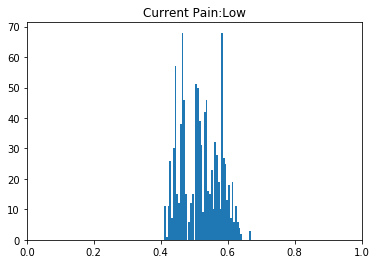

In [21]:
idx = 11
plt.hist(chain[:,7,:][:,idx], bins=50)
# plt.scatter(info['theta'][idx], 0, c='red')
plt.xlim(0,1)
plt.title(feature_name[idx])

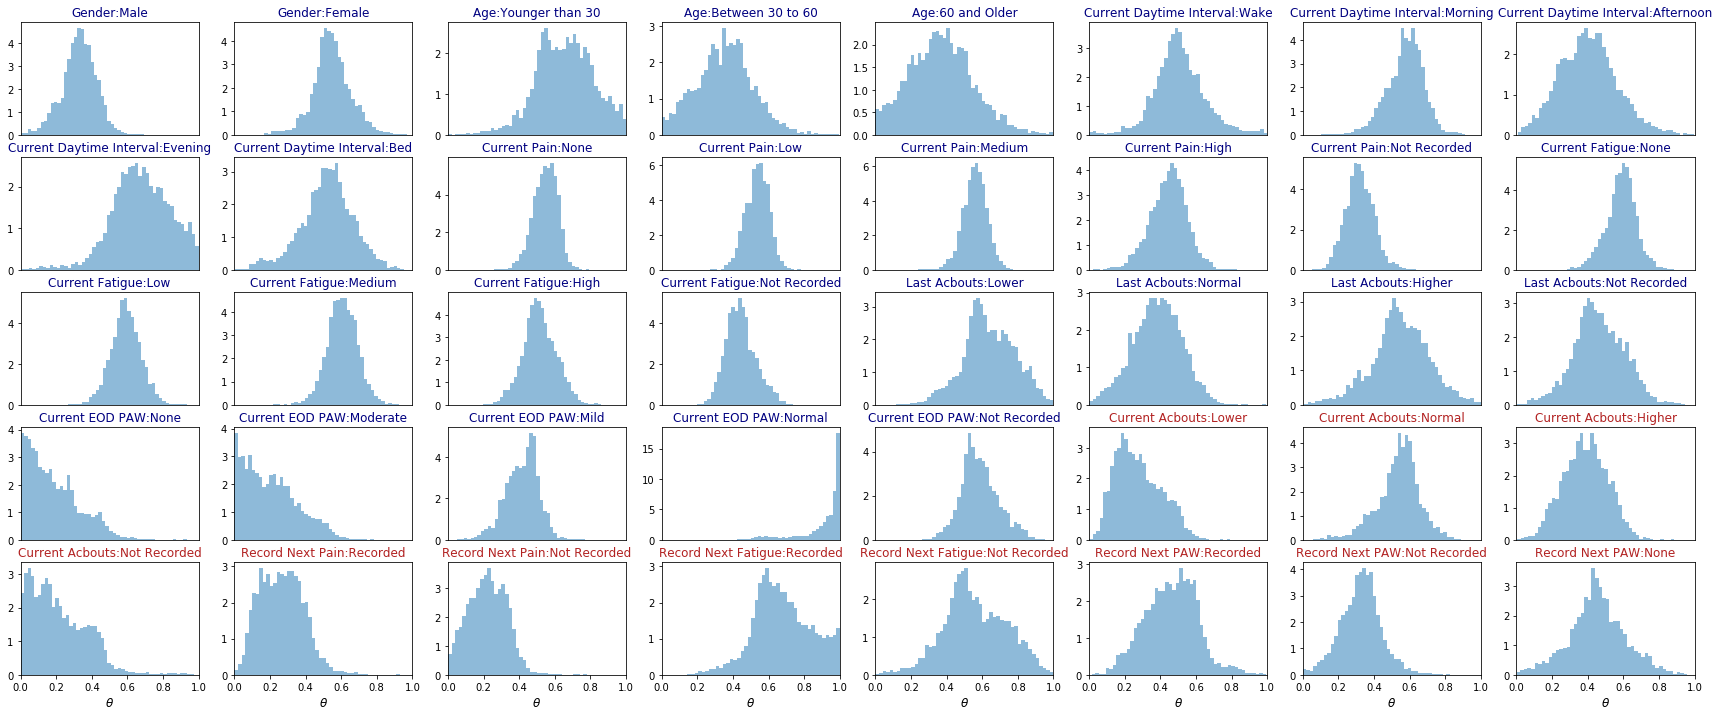

In [22]:
data = chain[:,:,:].reshape(-1, n_feature)
grid = np.linspace(0, 1, 1000)
plt.figure(figsize=(30,12))
n_row = 5
n_col = 8
fontc = np.append(['navy']*29, ['firebrick']*11)
for i in range(n_row):
    for j in range(n_col):
        k = i*n_col + j
        plt.subplot(n_row, n_col, k+1)
        plt.hist(data[:,k], bins=50, density=True, alpha=0.5)
#         kernel = stats.gaussian_kde(data[:,k])
#         pdf = kernel.pdf(grid)
#         plt.plot(grid, pdf)
#         plt.scatter(info['theta'][k], 0, c='r')
        plt.xlim(0, 1)
        plt.title(feature_name[k], fontsize=12, c=fontc[k])
        if i<n_row-1:
            plt.xticks([])
        if i==n_row-1:
            plt.xlabel('$\\theta$', fontsize=12)

### theta plot

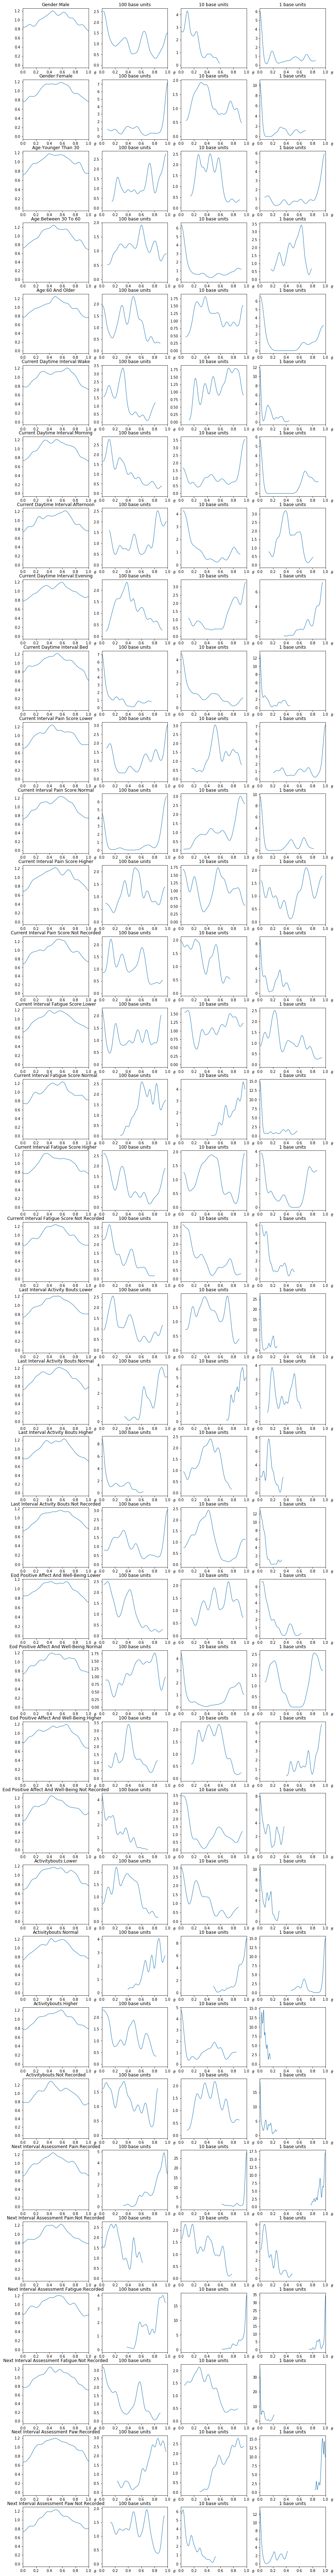

In [4]:
plt.figure(figsize=(15,130))
prior_sample = theta.random(size=4000)
for i in range(state_feature_matrix.shape[1]+action_feature_matrix.shape[1]):
    for j in range(len(n_base_list)+1):
        plt.subplot(state_feature_matrix.shape[1]+action_feature_matrix.shape[1], 
                    len(n_base_list)+1, i*(len(n_base_list)+1)+j+1)
        data = prior_sample[:,i] if j==0 else trace_list[j-1]['theta'][:,i]
        ax = pm.plots.kdeplot(data, textsize=10)
        ax.set_xlim(0, 1)
        if j==0:
            if i<state_feature_matrix.shape[1]:
                ax.set_title(environment.state_feature_names[i])
            else:
                ax.set_title(environment.action_feature_names[i-state_feature_matrix.shape[1]])
        else:
            ax.set_title('{} base units'.format(n_base_list[j-1]))
        ax.set_xlabel('$\\theta$', labelpad=-10, x=1.1)

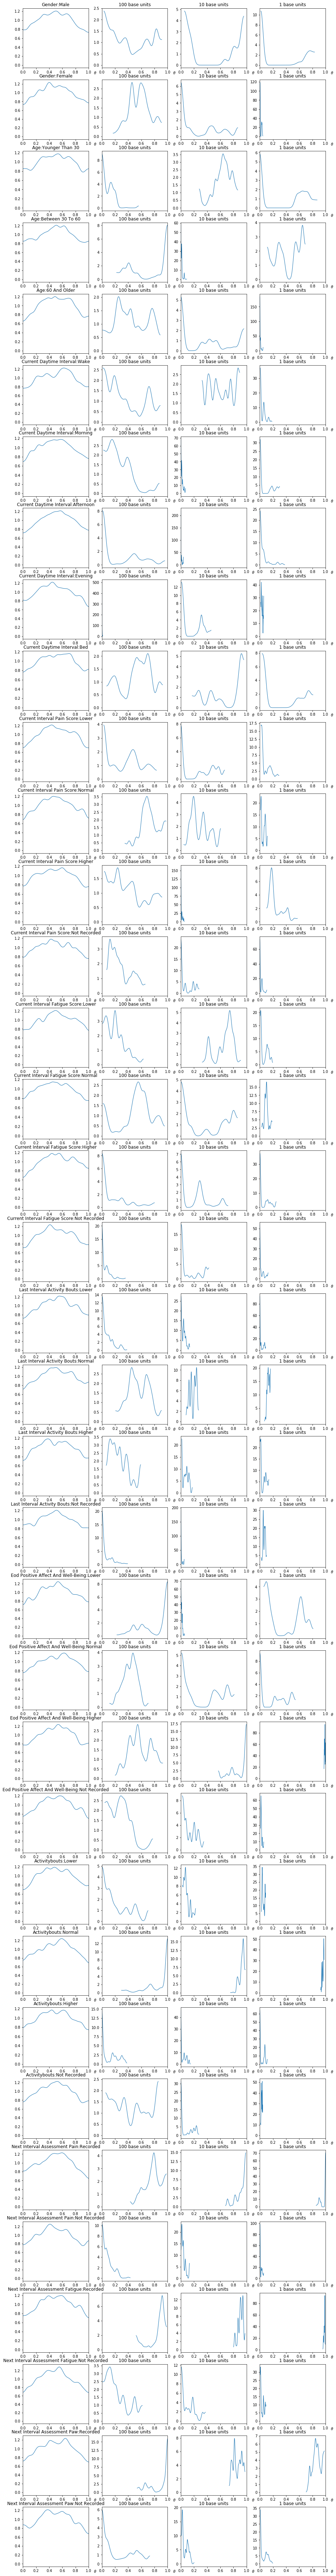

In [6]:
plt.figure(figsize=(15,130))
prior_sample = theta.random(size=4000)
for i in range(state_feature_matrix.shape[1]+action_feature_matrix.shape[1]):
    for j in range(len(n_base_list)+1):
        plt.subplot(state_feature_matrix.shape[1]+action_feature_matrix.shape[1], 
                    len(n_base_list)+1, i*(len(n_base_list)+1)+j+1)
        data = prior_sample[:,i] if j==0 else trace_list[j-1]['theta'][:,i]
        ax = pm.plots.kdeplot(data, textsize=10)
        ax.set_xlim(0, 1)
        if j==0:
            if i<state_feature_matrix.shape[1]:
                ax.set_title(environment.state_feature_names[i])
            else:
                ax.set_title(environment.action_feature_names[i-state_feature_matrix.shape[1]])
        else:
            ax.set_title('{} base units'.format(n_base_list[j-1]))
        ax.set_xlabel('$\\theta$', labelpad=-10, x=1.1)

### mu plot

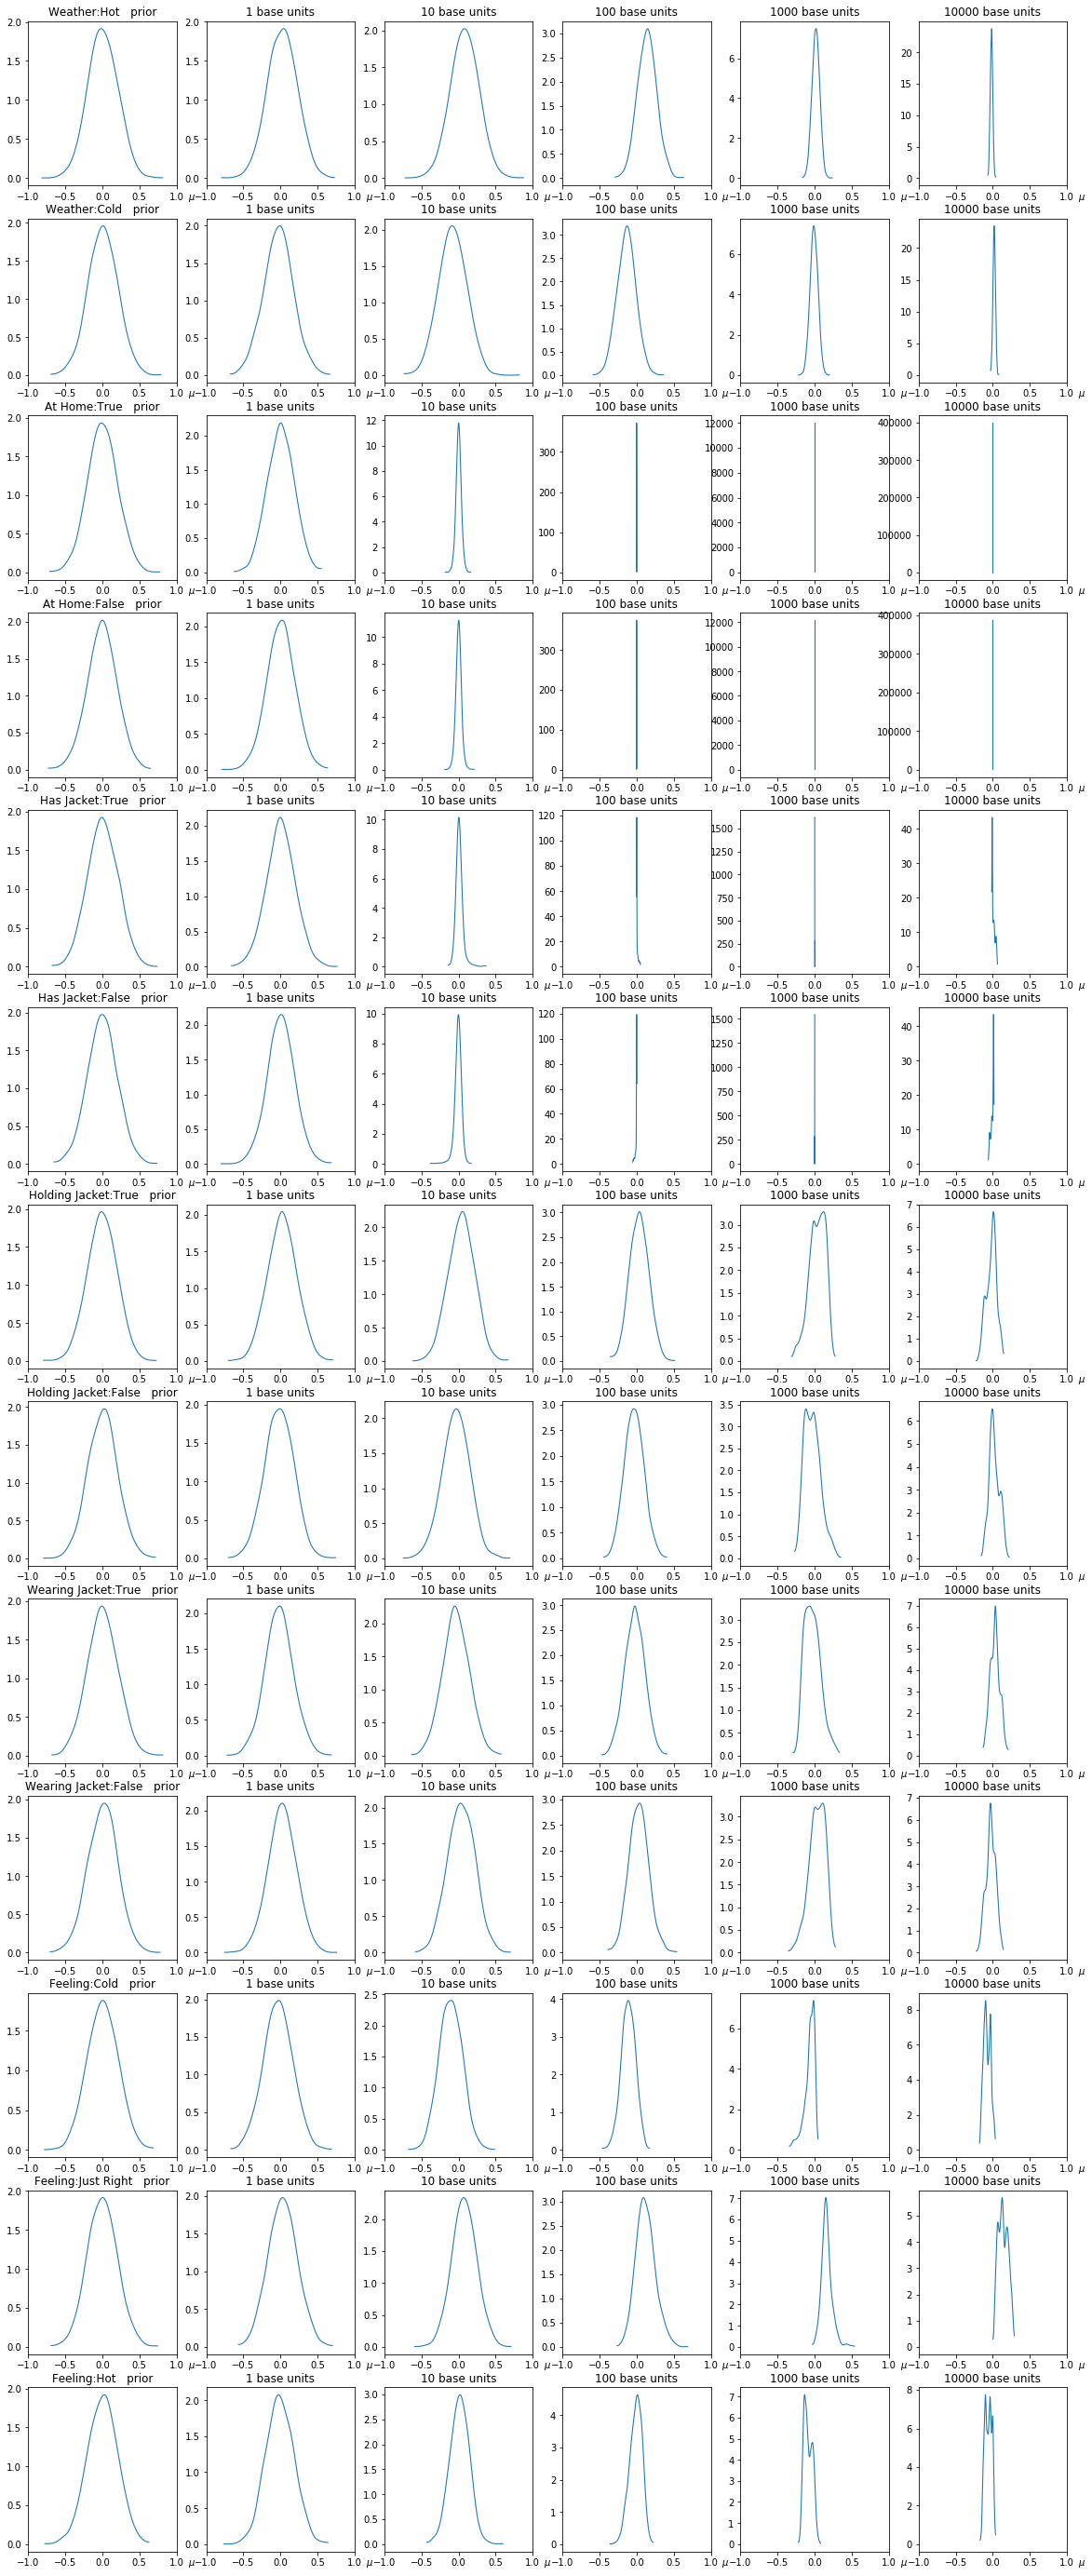

In [3]:
plt.figure(figsize=(20,50))
prior_sample = mu.random(size=4000)
for i in range(feature_matrix.shape[1]):
    for j in range(len(n_base_list)+1):
        plt.subplot(feature_matrix.shape[1], len(n_base_list)+1, i*(len(n_base_list)+1)+j+1)
        data = prior_sample[:,i] if j==0 else trace_list[j-1]['mu'][:,i]
        ax = pm.plots.kdeplot(data, textsize=10)
        ax.set_xlim(-1, 1)
        if j==0:
            ax.set_title(environment.state_feature_names[i]+'   prior')
        else:
            ax.set_title('{} base units'.format(n_base_list[j-1]))
        ax.set_xlabel('$\mu$', labelpad=-10, x=1.1)

### sigma plot

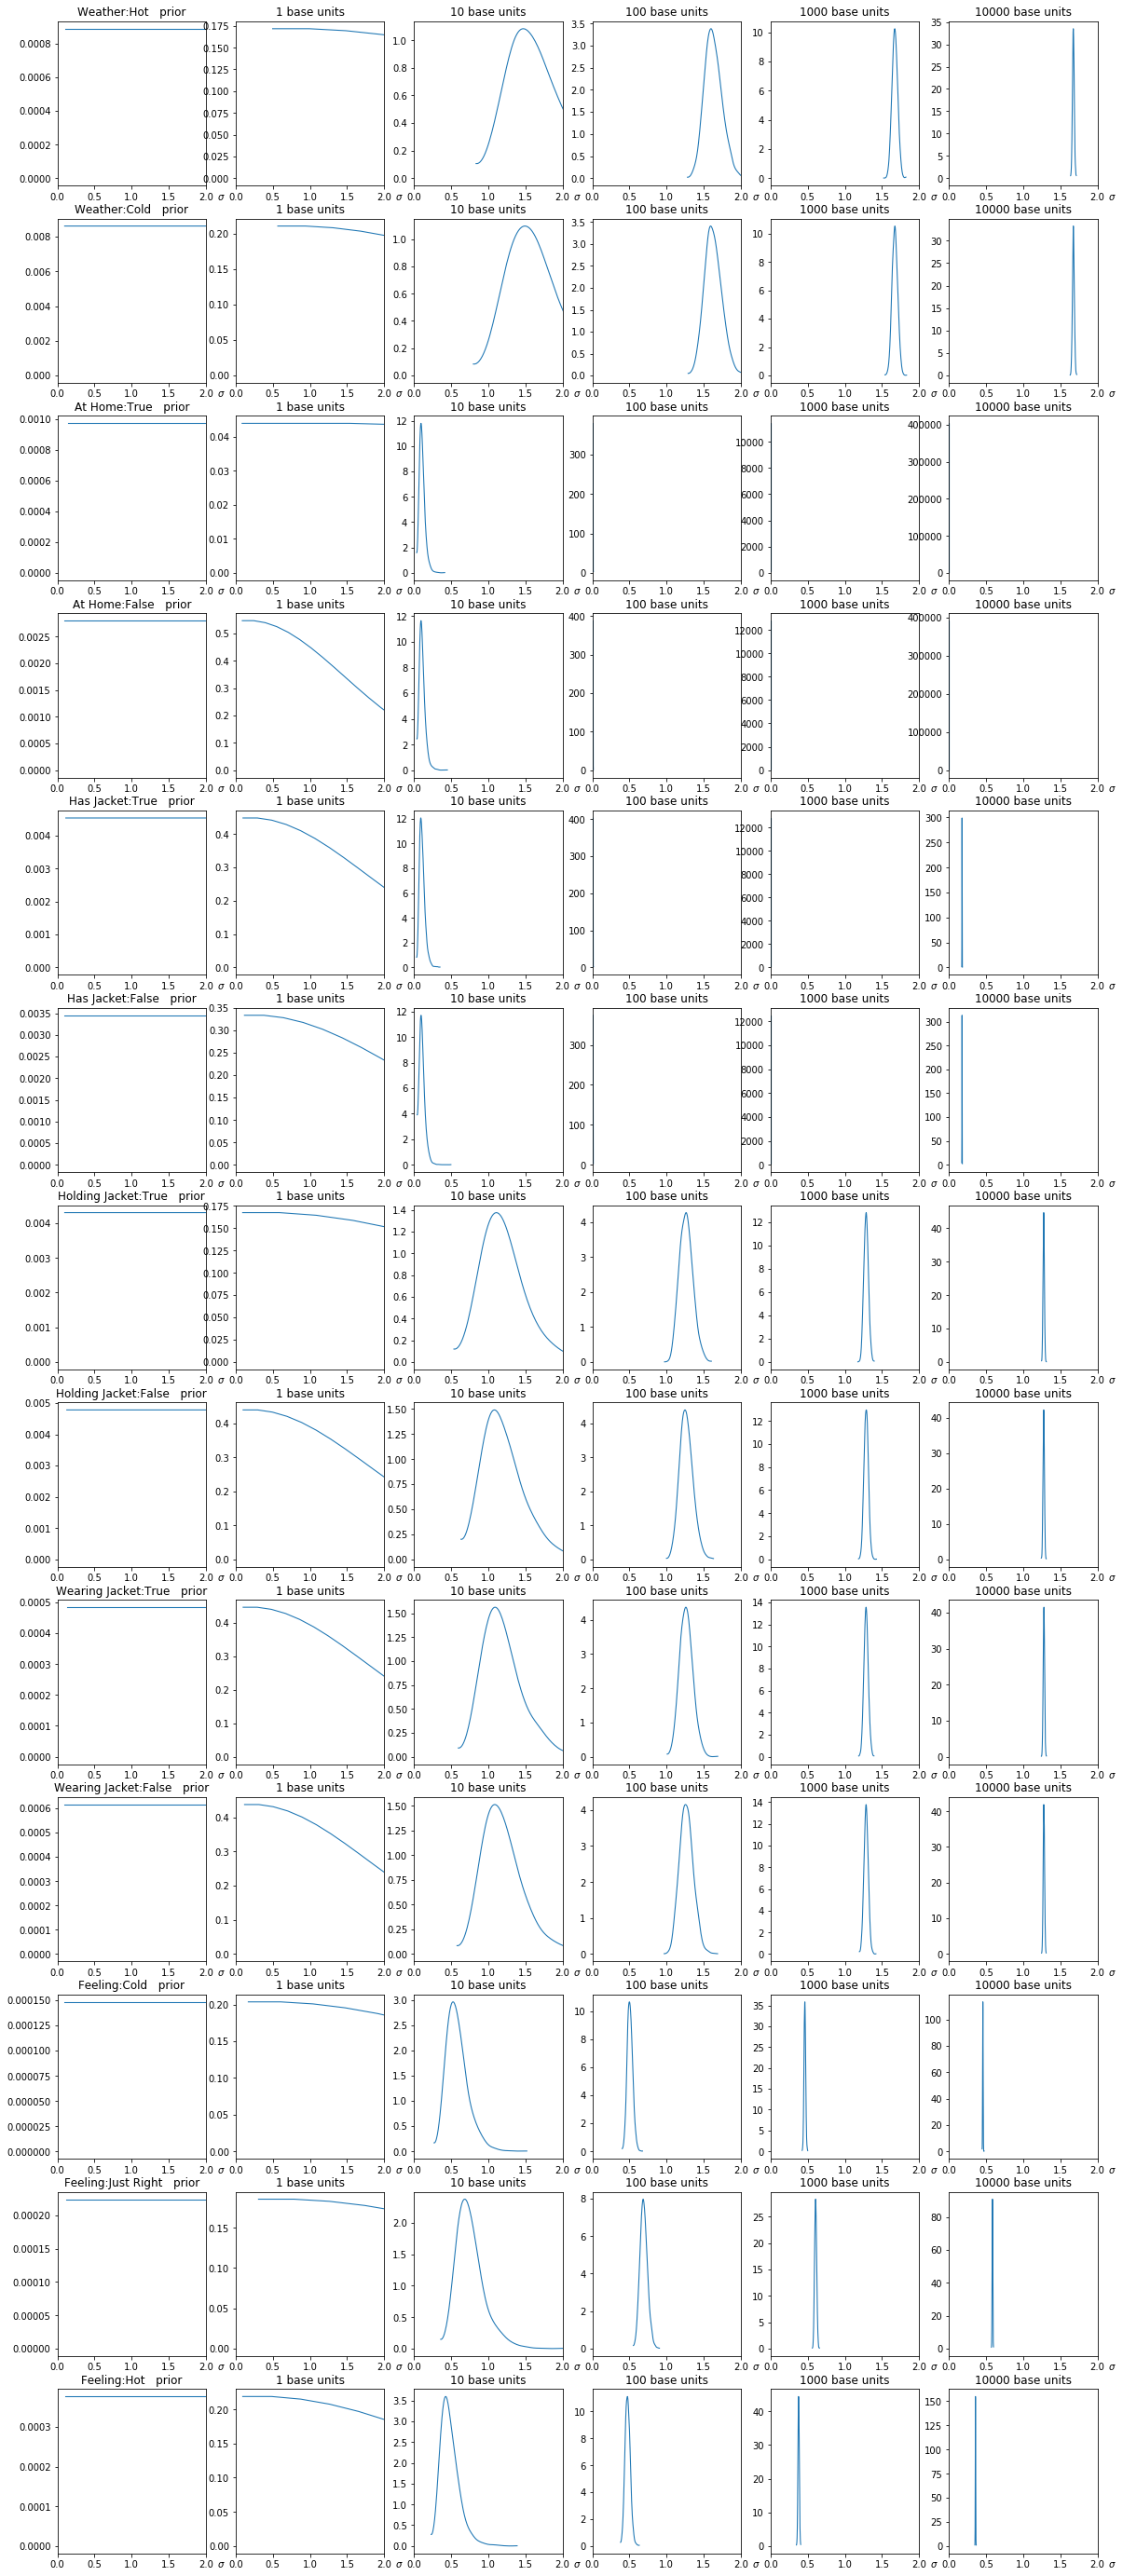

In [4]:
plt.figure(figsize=(20,50))
prior_sample = sigma.random(size=4000)
for i in range(feature_matrix.shape[1]):
    for j in range(len(n_base_list)+1):
        plt.subplot(feature_matrix.shape[1], len(n_base_list)+1, i*(len(n_base_list)+1)+j+1)
        data = prior_sample[:,i] if j==0 else trace_list[j-1]['sigma'][:,i]
        ax = pm.plots.kdeplot(data, textsize=10)
        ax.set_xlim(0, 2)
        if j==0:
            ax.set_title(environment.state_feature_names[i]+'   prior')
        else:
            ax.set_title('{} base units'.format(n_base_list[j-1]))
        ax.set_xlabel('$\sigma$', labelpad=-10, x=1.1)

### theta correlation plot

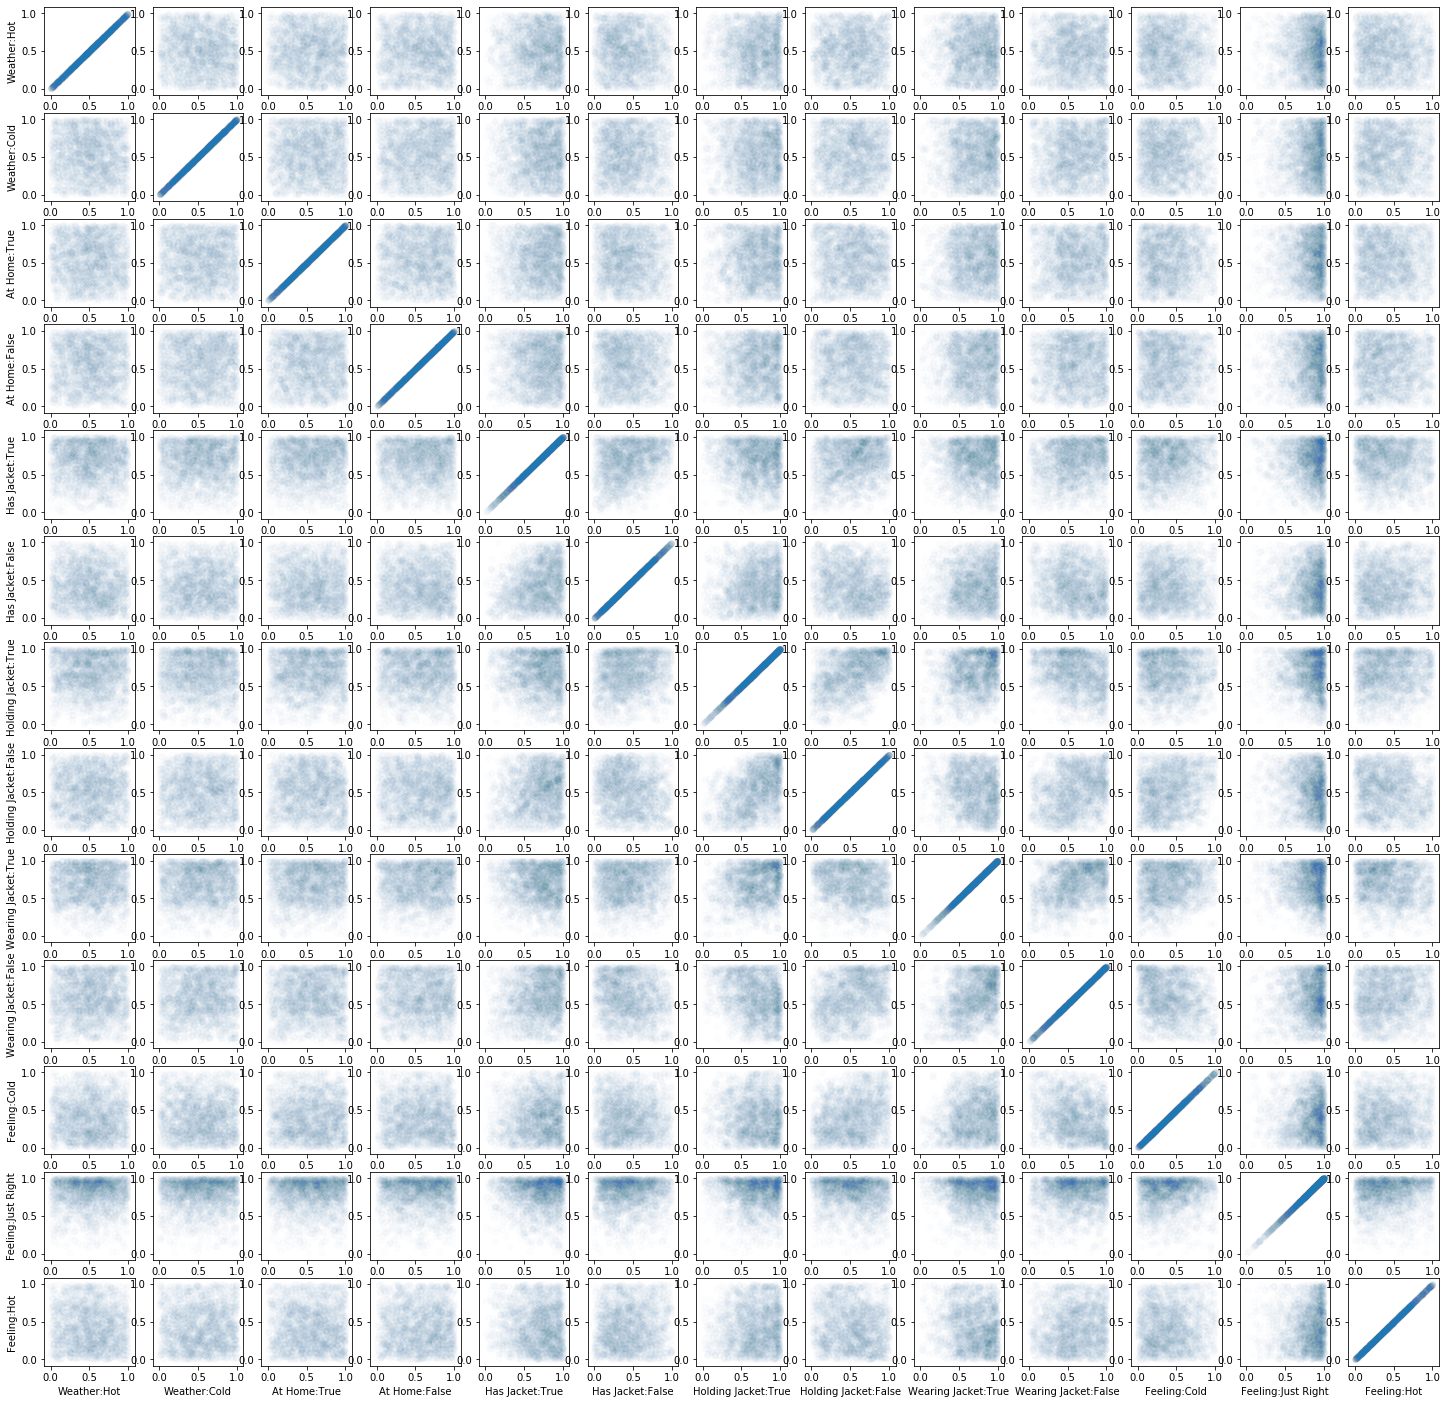

In [5]:
plt.figure(figsize=(25,25))
for i in range(feature_matrix.shape[1]):
    for j in range(feature_matrix.shape[1]):
        plt.subplot(feature_matrix.shape[1],feature_matrix.shape[1],i*feature_matrix.shape[1]+j+1)
        plt.scatter(trace_list[0]['theta'][:2000,j],trace_list[0]['theta'][:2000,i], alpha=0.01)
        if j==0:
            plt.ylabel(environment.state_feature_names[i])
        if i==feature_matrix.shape[1]-1:
            plt.xlabel(environment.state_feature_names[j])